In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path = '/content/drive/MyDrive/tweet1/labeled_data.csv'

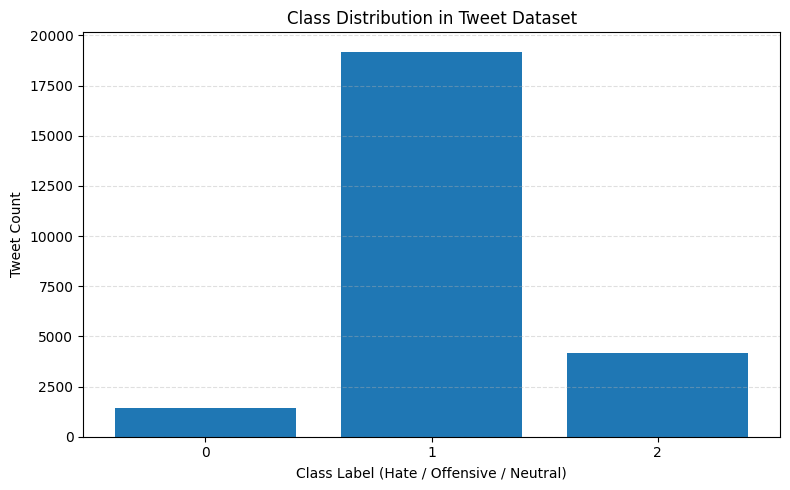

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def show_class_distribution(path="/content/drive/MyDrive/tweet1/labeled_data.csv", label_column="class"):

    try:
        # Load dataset
        df = pd.read_csv(path)

        # Check column exists
        if label_column not in df.columns:
            raise ValueError(f"Column '{label_column}' not found in dataset.")

        # Count classes
        counts = df[label_column].value_counts().sort_index()

        # Plot
        plt.figure(figsize=(8, 5))
        plt.bar(counts.index.astype(str), counts.values)

        plt.xlabel("Class Label (Hate / Offensive / Neutral)")
        plt.ylabel("Tweet Count")
        plt.title("Class Distribution in Tweet Dataset")

        plt.grid(axis='y', linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print("Error: File not found. Check dataset path.")
    except Exception as e:
        print(f"An error occurred: {e}")


# ✅ Run the function for your dataset
show_class_distribution("/content/drive/MyDrive/tweet1/labeled_data.csv", label_column="class")

In [4]:
import re
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Load the dataframe
df = pd.read_csv(data_path)

nltk.download('wordnet')
nltk.download('stopwords')
# অপ্রয়োজনীয় কলাম বাদ
df = df[['tweet', 'class']]
# Preprocessing function
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # URL বাদ
    text = re.sub(r'@\w+', '', text)  # mentions বাদ
    text = re.sub(r'#\w+', '', text)  # hashtag বাদ
    text = re.sub(r'\d+', '', text)  # number বাদ
    text = text.translate(str.maketrans('', '', string.punctuation))  # punctuation বাদ
    # Stopwords বাদ
    stop_words = set(stopwords.words('english'))
    words = [w for w in text.split() if w not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)
# Apply cleaning
df['clean_tweet'] = df['tweet'].apply(clean_text)
# Preview
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tweet,class,clean_tweet
0,!!! RT @mayasolovely: As a woman you shouldn't...,2,rt woman shouldnt complain cleaning house amp ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,rt boy dat coldtyga dwn bad cuffin dat hoe st ...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1,rt dawg rt ever fuck bitch start cry confused ...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1,rt look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,rt shit hear might true might faker bitch told ya


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature (X) এবং Label (y)
X = df['clean_tweet']
y = df['class']

# Train-Test Split (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # unigram + bigram
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Train shape:", X_train_tfidf.shape)
print("Test shape:", X_test_tfidf.shape)

Train shape: (19826, 5000)
Test shape: (4957, 5000)


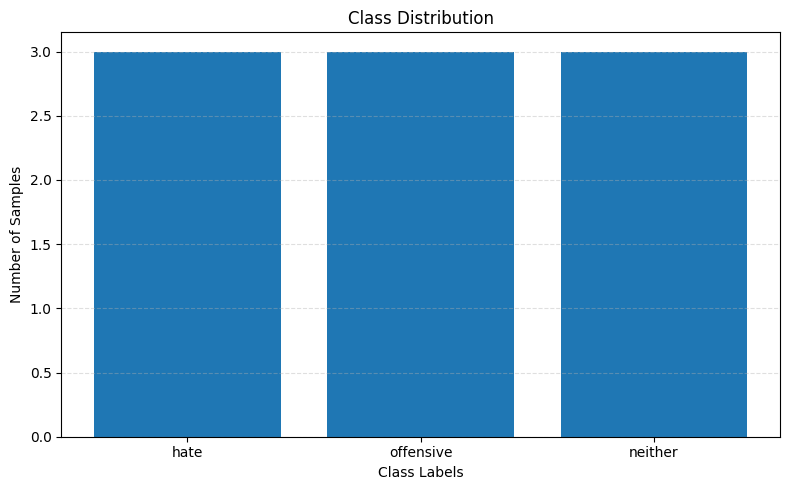

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution_from_list(labels):
    """
    Plots a bar chart of class distribution from a list of labels.

    Parameters:
        labels (list): A list containing class names for each sample.
    """
    try:
        if not labels:
            raise ValueError("Label list is empty.")

        # Count each class
        class_counts = Counter(labels)

        # Prepare data
        classes = list(class_counts.keys())
        counts = list(class_counts.values())

        # Plot
        plt.figure(figsize=(8, 5))
        plt.bar(classes, counts)
        plt.xlabel("Class Labels")
        plt.ylabel("Number of Samples")
        plt.title("Class Distribution")
        plt.grid(axis='y', linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")
# ✅ Example usage:
labels = [
    "hate", "hate", "offensive", "neither", "offensive",
    "offensive", "hate", "neither", "neither"
]
plot_class_distribution_from_list(labels)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# ১️⃣ Logistic Regression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

# ২️⃣ Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)

# ৩️⃣ XGBoost
xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
xgb.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb.predict(X_test_tfidf)

# 🧮 Evaluation Function
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"\n📊 {name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")

# Evaluate all models
evaluate_model("Logistic Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:08:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Logistic Regression Results:
Accuracy: 0.8941
Precision: 0.8816
Recall: 0.8941
F1-score: 0.8802

📊 Random Forest Results:
Accuracy: 0.8989
Precision: 0.8861
Recall: 0.8989
F1-score: 0.8848

📊 XGBoost Results:
Accuracy: 0.9040
Precision: 0.8953
Recall: 0.9040
F1-score: 0.8934


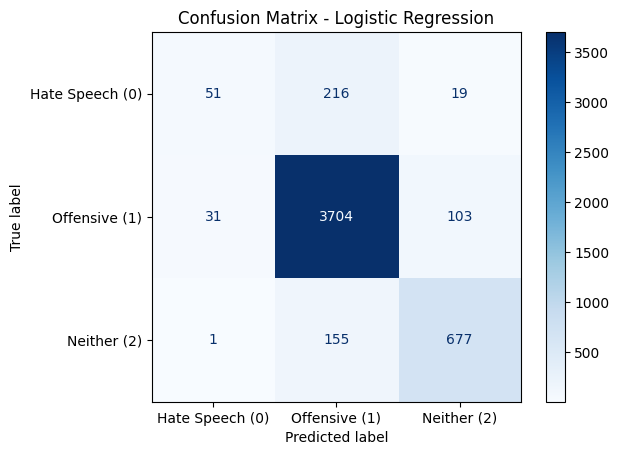

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Hate Speech (0)', 'Offensive (1)', 'Neither (2)'])
disp_lr.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

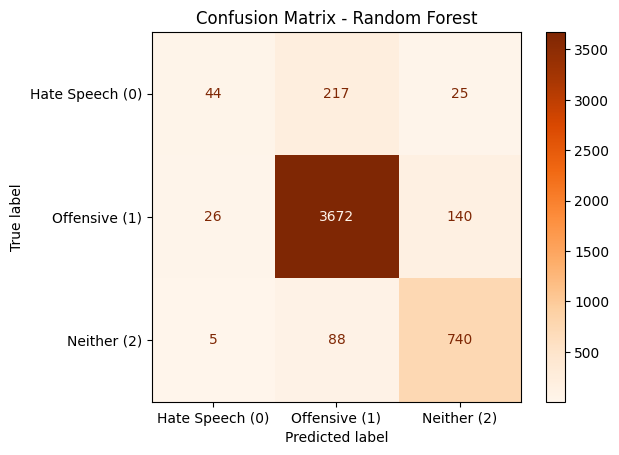

In [9]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Hate Speech (0)', 'Offensive (1)', 'Neither (2)'])
disp_rf.plot(cmap='Oranges', values_format='d')
plt.title("Confusion Matrix - Random Forest")
plt.show()

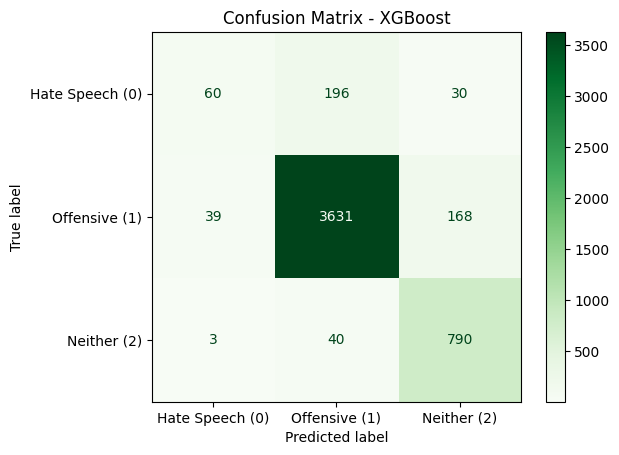

In [10]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Hate Speech (0)', 'Offensive (1)', 'Neither (2)'])
disp_xgb.plot(cmap='Greens', values_format='d')
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [11]:
!pip install transformers torch datasets tqdm

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

# শুধুমাত্র দরকারি কলাম
df = df[['clean_tweet', 'class']].rename(columns={'clean_tweet': 'text', 'class': 'label'})

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# HuggingFace Dataset এ convert
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

In [13]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [14]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"  # English tweets এর জন্য ভালো
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_tokenized = train_ds.map(tokenize_function, batched=True)
test_tokenized = test_ds.map(tokenize_function, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

In [15]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

# Model Load
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Metric Function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1}

# Training Arguments
training_args = TrainingArguments(
    output_dir="./hatebert_results",
    eval_strategy="epoch", # Corrected parameter name
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True
)

# Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2785939420.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.274900,0.264194,0.909219,0.894779
2,0.232400,0.261386,0.907807,0.898121
3,0.202500,0.277735,0.910026,0.903714


TrainOutput(global_step=3720, training_loss=0.24849007309124033, metrics={'train_runtime': 1465.1584, 'train_samples_per_second': 40.595, 'train_steps_per_second': 2.539, 'total_flos': 3912364964906496.0, 'train_loss': 0.24849007309124033, 'epoch': 3.0})

In [17]:
results = trainer.evaluate()
print("📊 HateBERT Evaluation Results:", results)

📊 HateBERT Evaluation Results: {'eval_loss': 0.2613861858844757, 'eval_accuracy': 0.9078071414161791, 'eval_f1': 0.8981206836582655, 'eval_runtime': 37.9992, 'eval_samples_per_second': 130.45, 'eval_steps_per_second': 8.158, 'epoch': 3.0}


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# --- TRAIN PREDICTIONS ---
train_preds = trainer.predict(train_tokenized)
train_labels = train_preds.label_ids
train_predictions = train_preds.predictions.argmax(-1)
# --- TEST PREDICTIONS ---
test_preds = trainer.predict(test_tokenized)
test_labels = test_preds.label_ids
test_predictions = test_preds.predictions.argmax(-1)
# --- TRAIN METRICS ---
train_acc = accuracy_score(train_labels, train_predictions)
train_prec = precision_score(train_labels, train_predictions, average='weighted')
train_rec = recall_score(train_labels, train_predictions, average='weighted')
train_f1 = f1_score(train_labels, train_predictions, average='weighted')
# --- TEST METRICS ---
test_acc = accuracy_score(test_labels, test_predictions)
test_prec = precision_score(test_labels, test_predictions, average='weighted')
test_rec = recall_score(test_labels, test_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
print("📊 TRAIN RESULTS:")
print(f"Accuracy: {train_acc:.4f}")
print(f"Precision: {train_prec:.4f}")
print(f"Recall: {train_rec:.4f}")
print(f"F1-score: {train_f1:.4f}")
print("\n📈 TEST RESULTS:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall: {test_rec:.4f}")
print(f"F1-score: {test_f1:.4f}")

📊 TRAIN RESULTS:
Accuracy: 0.9339
Precision: 0.9249
Recall: 0.9339
F1-score: 0.9255

📈 TEST RESULTS:
Accuracy: 0.9078
Precision: 0.8941
Recall: 0.9078
F1-score: 0.8981


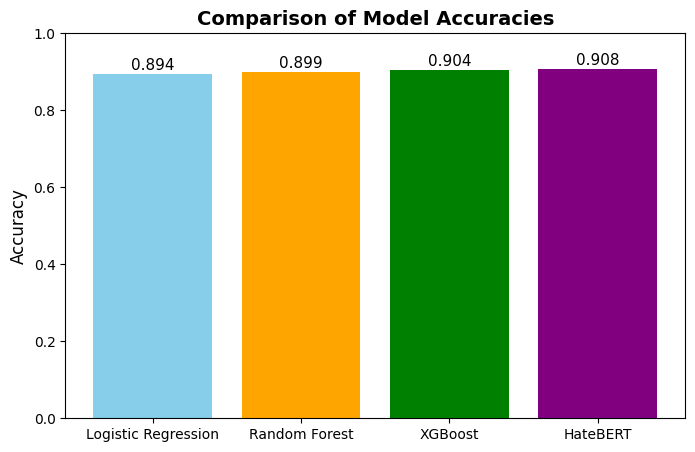

In [19]:
import matplotlib.pyplot as plt
# === Classical Models ===
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
# === Combine all accuracies ===
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'HateBERT']
accuracies = [acc_lr, acc_rf, acc_xgb, test_acc]
# === Visualization ===
plt.figure(figsize=(8,5))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'orange', 'green', 'purple'])
plt.title("Comparison of Model Accuracies", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1)
# প্রতিটি বারের উপরে accuracy মান দেখাবে
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.01, f"{acc:.3f}", ha='center', fontsize=11)
plt.show()

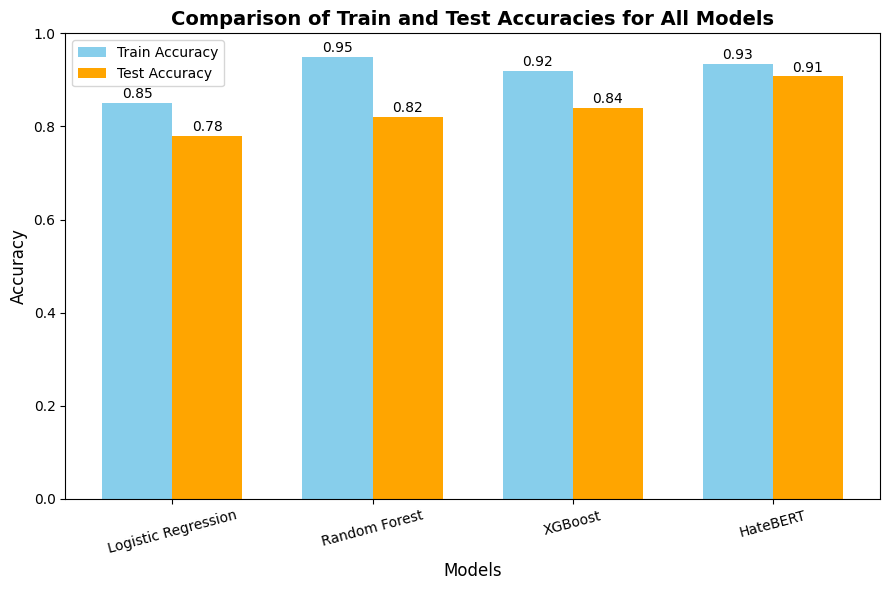

In [20]:
import matplotlib.pyplot as plt
import numpy as np
# === ধরো আগের মডেলগুলোর Accuracy ===
# (তুমি তোমার আসল মানগুলো বসিয়ে দিও নিচে)
train_acc_lr = 0.85
test_acc_lr  = 0.78
train_acc_rf = 0.95
test_acc_rf  = 0.82
train_acc_xgb = 0.92
test_acc_xgb  = 0.84
train_acc_bert = train_acc   # আগের code থেকে HateBERT train accuracy
test_acc_bert  = test_acc    # HateBERT test accuracy
# === Model names ===
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'HateBERT']
# === Accuracies ===
train_accuracies = [train_acc_lr, train_acc_rf, train_acc_xgb, train_acc_bert]
test_accuracies  = [test_acc_lr, test_acc_rf, test_acc_xgb, test_acc_bert]
# === Bar chart setup ===
x = np.arange(len(models))
width = 0.35
plt.figure(figsize=(9,6))
bars1 = plt.bar(x - width/2, train_accuracies, width, label='Train Accuracy', color='skyblue')
bars2 = plt.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='orange')
# === Labels and title ===
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Comparison of Train and Test Accuracies for All Models", fontsize=14, fontweight='bold')
plt.xticks(x, models, rotation=15)
plt.ylim(0, 1)
plt.legend()
# === Bar values show ===
for bar in bars1 + bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{bar.get_height():.2f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# === TRAIN DATA PREDICTION ===
train_preds = trainer.predict(train_tokenized)
train_labels = train_preds.label_ids
train_predictions = train_preds.predictions.argmax(-1)
# === TEST DATA PREDICTION ===
test_preds = trainer.predict(test_tokenized)
test_labels = test_preds.label_ids
test_predictions = test_preds.predictions.argmax(-1)
# === TRAIN METRICS ===
train_acc = accuracy_score(train_labels, train_predictions)
train_prec = precision_score(train_labels, train_predictions, average='weighted')
train_rec = recall_score(train_labels, train_predictions, average='weighted')
train_f1 = f1_score(train_labels, train_predictions, average='weighted')
print("📊 TRAIN METRICS")
print("-----------------")
print(f"Accuracy : {train_acc:.4f}")
print(f"Precision: {train_prec:.4f}")
print(f"Recall   : {train_rec:.4f}")
print(f"F1-score : {train_f1:.4f}")
# === TEST METRICS ===
test_acc = accuracy_score(test_labels, test_predictions)
test_prec = precision_score(test_labels, test_predictions, average='weighted')
test_rec = recall_score(test_labels, test_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
print("\n📈 TEST METRICS")
print("----------------")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall   : {test_rec:.4f}")
print(f"F1-score : {test_f1:.4f}")
# === Optional: Detailed classification report ===
print("\nDetailed Classification Report (Test Data):")
print(classification_report(test_labels, test_predictions))

📊 TRAIN METRICS
-----------------
Accuracy : 0.9339
Precision: 0.9249
Recall   : 0.9339
F1-score : 0.9255

📈 TEST METRICS
----------------
Accuracy : 0.9078
Precision: 0.8941
Recall   : 0.9078
F1-score : 0.8981

Detailed Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.47      0.22      0.30       286
           1       0.93      0.96      0.95      3838
           2       0.86      0.90      0.88       833

    accuracy                           0.91      4957
   macro avg       0.76      0.69      0.71      4957
weighted avg       0.89      0.91      0.90      4957



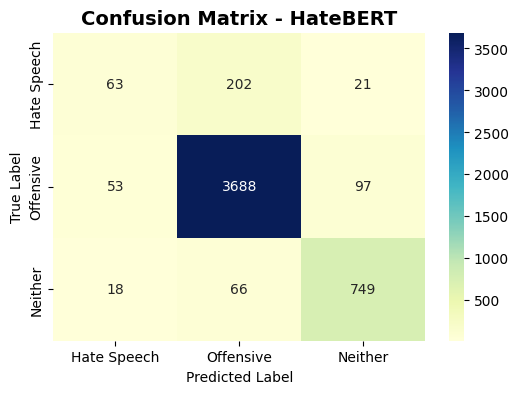

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# === Confusion Matrix ===
test_cm = confusion_matrix(test_labels, test_predictions)

# === Class names (replace if different) ===
class_names = ["Hate Speech", "Offensive", "Neither"]

# === Visualization ===
plt.figure(figsize=(6,4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='YlGnBu', # Corrected colormap name
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - HateBERT", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

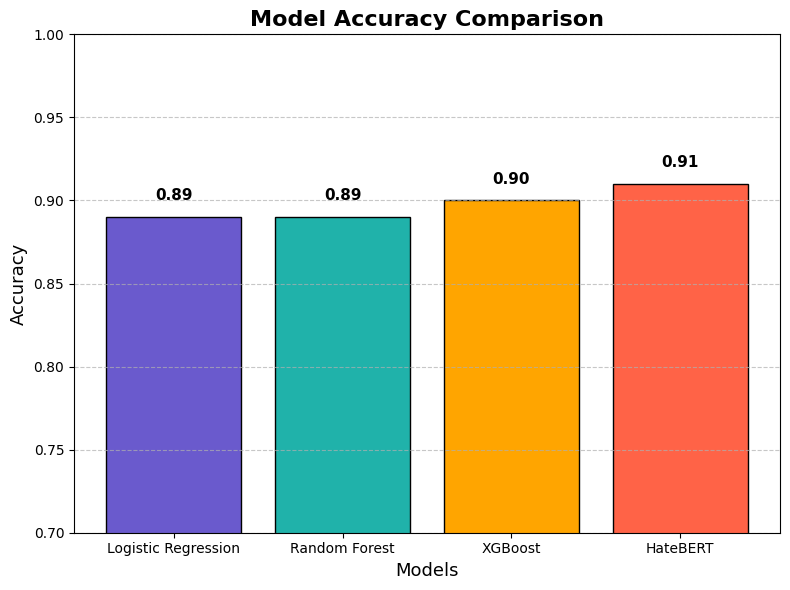

In [24]:
# Import necessary library
import matplotlib.pyplot as plt

# === Model Accuracy Data ===
models = ["Logistic Regression", "Random Forest", "XGBoost", "HateBERT"]
accuracy = [0.89, 0.89, 0.90, 0.91]

# === Plot Configuration ===
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracy, color=['#6A5ACD', '#20B2AA', '#FFA500', '#FF6347'], edgecolor='black')

# === Title and Labels ===
plt.title("Model Accuracy Comparison", fontsize=16, fontweight='bold')
plt.xlabel("Models", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# === Annotate Bars with Accuracy Values ===
for bar, acc in zip(bars, accuracy):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.01, f"{acc:.2f}",
             ha='center', fontsize=11, fontweight='bold', color='black')

# === Layout and Show Plot ===
plt.tight_layout()
plt.show()

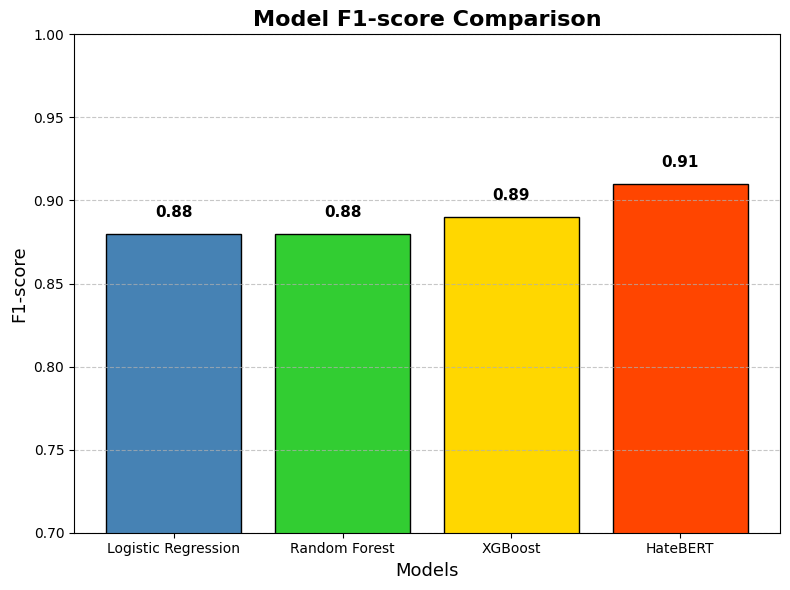

In [25]:
# Import library
import matplotlib.pyplot as plt

# === Model F1-score Data ===
models = ["Logistic Regression", "Random Forest", "XGBoost", "HateBERT"]
f1_scores = [0.88, 0.88, 0.89, 0.91]

# === Plot Configuration ===
plt.figure(figsize=(8, 6))
bars = plt.bar(models, f1_scores, color=['#4682B4', '#32CD32', '#FFD700', '#FF4500'], edgecolor='black')

# === Title and Labels ===
plt.title("Model F1-score Comparison", fontsize=16, fontweight='bold')
plt.xlabel("Models", fontsize=13)
plt.ylabel("F1-score", fontsize=13)
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# === Annotate Bars with F1 Values ===
for bar, f1 in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, f1 + 0.01, f"{f1:.2f}",
             ha='center', fontsize=11, fontweight='bold', color='black')

# === Layout and Show Plot ===
plt.tight_layout()
plt.show()